# Generative Adversial Neural Network for Galaxy Image Generation

## 1. Dataset

In [10]:
import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt
import os

In [6]:
dataset_path = 'dataset/'
dataset_files = np.array([f'{dataset_path}/{file}' for file in os.listdir(dataset_path) if 'jpg' in file])

In [7]:
dataset_files

array(['dataset//337902.jpg', 'dataset//746665.jpg',
       'dataset//246791.jpg', ..., 'dataset//579903.jpg',
       'dataset//399727.jpg', 'dataset//543154.jpg'], dtype='<U19')

In [12]:
from PIL import Image

In [127]:
class ImagesBatchGenerator(keras.utils.Sequence):
    """_summary_
    Helps to iterate over the dataset
    Args:
        keras (_type_): _description_
    """

    def __init__(self, dataset_files, batch_size, image_size):
        self.dataset_files = dataset_files
        self.batch_size = batch_size
        self.image_size = image_size
    
    def __len__(self):
        return len(self.dataset_files)

    def __getitem__(self, idx):
        """Returns tuple (input, output) that corresponds to batch idx"""
        
        subset = self.dataset_files[idx:idx+self.batch_size]
        
        # Read and return
        return np.array([np.asarray(Image.open(path).convert('L').resize(self.image_size)) / 255 for path in subset])
    
    
    def show_subset(self, idx, ncols=4):
        images = self.__getitem__(idx)
        nrows = self.batch_size // ncols
        
        fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,20))
        for i in range(4):
            ax[i].imshow(np.squeeze(images[i]))
            ax[i].title.set_text(i)

In [128]:
real_images = ImagesBatchGenerator(dataset_files, batch_size=4, image_size=(64,64))

In [130]:
real_images.__getitem__(0)

array([[[0.02745098, 0.04705882, 0.00392157, ..., 0.05098039,
         0.03137255, 0.01568627],
        [0.01960784, 0.01568627, 0.01568627, ..., 0.01960784,
         0.01568627, 0.00784314],
        [0.00392157, 0.00784314, 0.03529412, ..., 0.00784314,
         0.01176471, 0.01176471],
        ...,
        [0.00392157, 0.01176471, 0.01568627, ..., 0.01568627,
         0.03137255, 0.03921569],
        [0.01960784, 0.00784314, 0.00784314, ..., 0.03529412,
         0.02745098, 0.01960784],
        [0.02745098, 0.02352941, 0.00784314, ..., 0.01568627,
         0.00392157, 0.01568627]],

       [[0.01960784, 0.03529412, 0.02352941, ..., 0.01568627,
         0.02352941, 0.00784314],
        [0.01960784, 0.02745098, 0.01568627, ..., 0.00784314,
         0.00784314, 0.00784314],
        [0.01176471, 0.01176471, 0.00784314, ..., 0.01960784,
         0.00784314, 0.00784314],
        ...,
        [0.00784314, 0.00784314, 0.00392157, ..., 0.01176471,
         0.00784314, 0.01176471],
        [0.0

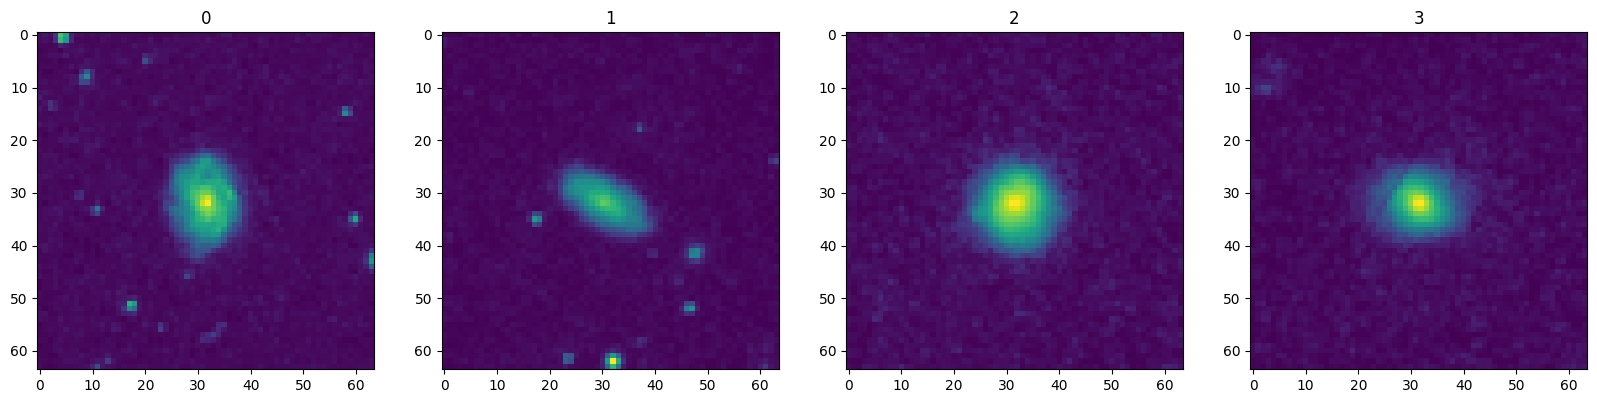

In [131]:
real_images.show_subset(1)

## 2. Build Neural Networks

### 2.1. Import MOdelling Components

In [72]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 2.2. Build Generator

In [85]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(8*8*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8,8,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 3
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1,4,padding='same', activation='sigmoid'))
    
    return model

In [86]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                      

In [87]:
img = generator.predict(np.random.randn(4,128,1))
img

1/1 [==============================] - 0s 292ms/step


array([[[[0.49895826],
         [0.4992838 ],
         [0.49840495],
         ...,
         [0.5020661 ],
         [0.50286686],
         [0.50313455]],

        [[0.49789822],
         [0.49752334],
         [0.4961255 ],
         ...,
         [0.50270027],
         [0.50359803],
         [0.5032017 ]],

        [[0.49750313],
         [0.49534026],
         [0.49240923],
         ...,
         [0.50278926],
         [0.5038758 ],
         [0.5020132 ]],

        ...,

        [[0.49891645],
         [0.5001059 ],
         [0.4989559 ],
         ...,
         [0.50143105],
         [0.49987018],
         [0.5007395 ]],

        [[0.50000006],
         [0.5006566 ],
         [0.49915394],
         ...,
         [0.5015939 ],
         [0.4998784 ],
         [0.5005313 ]],

        [[0.49810058],
         [0.49913073],
         [0.499629  ],
         ...,
         [0.5005833 ],
         [0.49955225],
         [0.49996322]]],


       [[[0.49953797],
         [0.49989307],
         [0.50

1/1 [==============================] - 0s 118ms/step


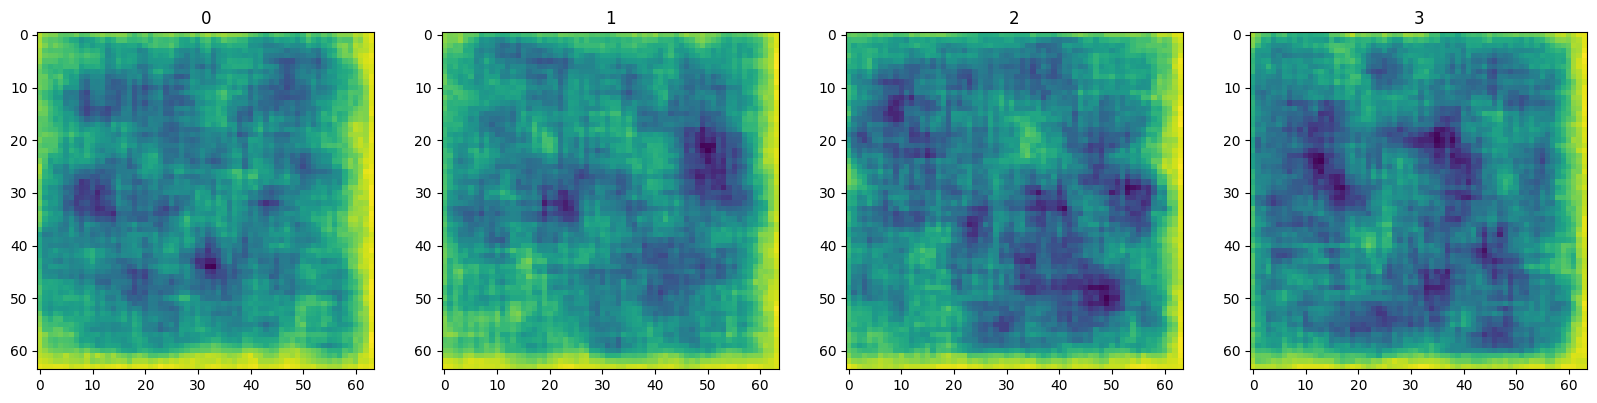

In [135]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, im in enumerate(img):
    ax[idx].imshow(np.squeeze(im))
    ax[idx].title.set_text(idx)

### 2.3. Build Discriminator

In [97]:
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(64,64,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [98]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 60, 60, 32)        832       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 60, 60, 32)        0         
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 64)        51264     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 56, 56, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 52, 52, 128)      

In [111]:
img.shape

(4, 64, 64, 1)

In [106]:
discriminator.predict(img)

1/1 [==============================] - 0s 80ms/step


array([[0.50507694],
       [0.50504416],
       [0.50512767],
       [0.50508684]], dtype=float32)

## 3. Training Loop

### 3.1. Losses and Optimzizers

In [114]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [115]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 3.2. Custom Model

In [116]:
from keras.models import Model

Input example

In [117]:
tf.random.normal((6, 128, 1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 4.11280423e-01],
        [ 7.91456342e-01],
        [ 1.25492632e+00],
        [-9.55944240e-01],
        [ 6.33452773e-01],
        [ 8.73054802e-01],
        [ 6.95856690e-01],
        [ 3.16279978e-01],
        [-8.51969600e-01],
        [-4.83283311e-01],
        [ 2.50234628e+00],
        [-5.99137656e-02],
        [-6.50712311e-01],
        [-1.53849256e+00],
        [-1.76731539e+00],
        [ 2.78084922e+00],
        [ 2.84834832e-01],
        [ 8.42542112e-01],
        [ 1.59996831e+00],
        [ 4.45947677e-01],
        [-3.29440445e-01],
        [ 1.94121897e+00],
        [-1.17391491e+00],
        [-5.88112712e-01],
        [-2.93184191e-01],
        [-1.04589069e+00],
        [-1.84398860e-01],
        [-6.45468831e-01],
        [ 2.98663020e-01],
        [ 6.58391356e-01],
        [-2.76027226e+00],
        [-6.53304875e-01],
        [-3.62160116e-01],
        [ 4.81762171e-01],
        [-5.62125564e-01],
  

In [118]:
class GalaxyGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    
    def train_step(self, batch):
        # Get data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) # Should be all zeros
            yhat_fake = self.discriminator(fake_images, training=True) # Should be all ones
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
        
            # Add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0) 
            
            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagtion - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            
            # Calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
            

In [119]:
galaxy_gan = GalaxyGAN(generator, discriminator)

In [120]:
galaxy_gan.compile(g_opt, d_opt, g_loss, d_loss)

### 3.3. Callbacks

In [122]:
from tensorflow.keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

In [123]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 3.4. Train

In [132]:
hist = galaxy_gan.fit(real_images, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20


2022-11-04 17:08:45.086024: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 177209344 exceeds 10% of free system memory.
2022-11-04 17:08:45.086382: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 58982400 exceeds 10% of free system memory.
2022-11-04 17:08:45.086450: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 102760448 exceeds 10% of free system memory.
2022-11-04 17:08:45.086499: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 301989888 exceeds 10% of free system memory.
2022-11-04 17:08:45.086545: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 301989888 exceeds 10% of free system memory.


KeyboardInterrupt: 